In [1]:
import os
#Set current location to the location of the script
os.chdir("/dust3r")
print(os.getcwd())

/dust3r


In [2]:
#Display imgs
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d
import torch

from dust3r.inference import inference, inference_with_mask
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"
IMG_FILE_EXTENSION = ".png"
MASK_FILE_EXTENSION = ".png"
device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [3]:
model_name = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [4]:
# load_images can take a list of images or a directory

images_array = []
masks_array = []

for i in range(15):
    images_array.append(os.path.join(DATA_PATH,"masked_images/{}{}".format(i,IMG_FILE_EXTENSION)))
    masks_array.append(os.path.join(DATA_PATH,"masks/{}{}".format(i,MASK_FILE_EXTENSION)))
images = load_images(images_array, size=512, verbose=True)

masks = []

for i in range(len(masks_array)):
    #Open as mask and load to gpu
    mask = Image.open(masks_array[i]).convert('L')
    #Resize to match image size
    _,_,H,W = images[i]["img"].shape
    mask = mask.resize((W,H))

    mask = np.array(mask)
    mask = torch.tensor(mask).to(device)/255
    masks.append(mask)

>> Loading a list of 15 images
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/0.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/1.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/2.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/3.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/4.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/5.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/6.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/data/jackal_training_data_0/masked_images/7.png with resolution 1280x720 --> 512x288
 - adding /dust3r/masked_dust3r/d

In [5]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference_with_mask(pairs, model, device, masks, batch_size=batch_size)
#output = inference(pairs, model, device, batch_size=batch_size)

view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

>> Inference with model on 210 image pairs


  0%|          | 0/210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 210/210 [01:26<00:00,  2.44it/s]


In [6]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

 init edge (3*,5*) score=1.2058569192886353
 init edge (3,6*) score=1.2041503190994263
 init edge (3,8*) score=1.192130208015442
 init edge (4*,8) score=1.1913957595825195
 init edge (3,7*) score=1.1802425384521484
 init edge (3,9*) score=1.168657660484314
 init edge (3,2*) score=1.1556755304336548
 init edge (4,10*) score=1.154893398284912
 init edge (1*,6) score=1.1510189771652222
 init edge (5,11*) score=1.1341043710708618
 init edge (6,0*) score=1.1211603879928589
 init edge (6,14*) score=1.096208095550537
 init edge (6,12*) score=1.0902040004730225
 init edge (6,13*) score=1.0545775890350342
 init loss = 0.00020294601563364267
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [01:35<00:00,  3.13it/s, lr=1.27413e-06 loss=7.841e-05]  


In [7]:
#Check if pointclouds folder exists
#If exists, delete all files in the folder
if os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    for file in os.listdir("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
        os.remove("{DATA_PATH}/pointclouds/{file}".format(DATA_PATH=DATA_PATH, file=file))
        
if not os.path.exists("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH)):
    os.makedirs("{DATA_PATH}/pointclouds".format(DATA_PATH=DATA_PATH))

for i in range(len(images)):
    pointcloud = pts3d[i].detach().cpu().numpy()
    pointcloud = pointcloud.reshape(-1, 3)
    color = imgs[i].reshape(-1, 3)
    confidence_mask = confidence_masks[i].detach().cpu().numpy()
    confidence_mask = confidence_mask.reshape(-1)
    
    masked_pointcloud = []
    masked_color = []

    for j in range(len(confidence_mask)):
        if confidence_mask[j]:
            masked_pointcloud.append(pointcloud[j])
            masked_color.append(color[j])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(masked_pointcloud)
    pcd.colors = o3d.utility.Vector3dVector(masked_color)
    o3d.io.write_point_cloud("{DATA_PATH}/pointclouds/pointcloud{i}.ply".format(DATA_PATH=DATA_PATH, i=i), pcd)

[Open3D WARNING] Write PLY failed: point cloud has 0 points.


(-0.5, 511.5, 287.5, -0.5)

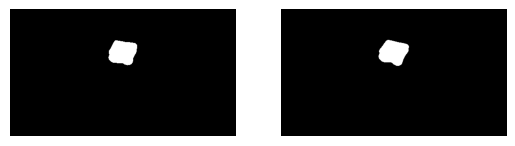

In [8]:
conf1 = confidence_masks[2].cpu().numpy()
conf2 = confidence_masks[3].cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(conf1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conf2, cmap='gray')
plt.axis('off')

In [17]:
import json

#Create transform file
#TODO: Per frame camera model?
transform = {}
transform["camera_model"] = "OPENCV"

averge_focal = focals.sum()/len(focals)
transform["fl_x"] = averge_focal.item()
transform["fl_y"] = averge_focal.item()

#Find size of images
img = Image.open(images_array[0])
width, height = img.size
transform["w"] = width
transform["h"] = height
transform["c_x"] = width//2
transform["c_y"] = height//2

transform["frames"] = []

for i in range(len(poses)):
    frame = {}
    frame["file_path"] = "images/{}{}".format(i,IMG_FILE_EXTENSION)
    frame["transform_matrix"] = poses[i].detach().cpu().numpy().tolist()
    frame["mask_path"] = "masks/{}{}".format(i,MASK_FILE_EXTENSION)
    transform["frames"].append(frame)

#Save transform file
with open("{}/transforms.json".format(DATA_PATH), 'w') as f:
    json.dump(transform, f, indent=4)